In [1]:
from __future__ import print_function

# MNIST example

We will perform a simple analysis on MNIST to identify which pixels to erase to convert digits from one class into another class. We will compare importance scores computed using a variety of methods.

## Obtain data and keras model

We will load a keras model and compute importance scores

### Download the keras model

Download a model with 2 strided convolutional layers and 2 dense layers, similar to the one in the paper.

In [2]:
!./grab_model.sh

File mnist_cnn_allconv_tensorflow.h5 exists already


### Load the keras model

In [3]:
import keras
keras_model = keras.models.load_model("mnist_cnn_allconv_tensorflow.h5")
keras_model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 13, 13, 32)    544         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 13, 13, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 5, 5, 64)      32832       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 5, 5, 64)      0           convolution2d_2[0][0]            
___________________________________________________________________________________________

### Load the data

In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test = X_test[:,:,:,None]

## Prepare the deeplift models

### Model conversion

Convert the keras models to deeplift models capable of computing importance scores using DeepLIFT-RevealCancel, gradients and guided backprop

In [5]:
import deeplift
from deeplift.blobs import NonlinearMxtsMode
from deeplift.conversion import keras_conversion as kc

#Three different models, one each for RevealCancel, Gradient and GuidedBackprop
revealcancel_model = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
grad_model = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.Gradient)
guided_backprop_model = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.GuidedBackprop)

nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: Gradient
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: GuidedBackprop
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case


### Sanity checks

To ensure that the conversion happend correctly, ensure that the models give identical predictions

In [11]:
from deeplift.util import compile_func
import numpy as np
from keras import backend as K

deeplift_model = revealcancel_model
deeplift_prediction_func = compile_func([deeplift_model.get_layers()[0].get_activation_vars()],
                                       deeplift_model.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(X_test, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[X_test],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

difference in predictions: 6.13928e-06


## Compute importance scores

### Compile various scoring functions

Using the deeplift models, we obtain the functions capable of computing the importance scores.

In [12]:
from keras import backend as K
import deeplift
from deeplift.util import get_integrated_gradients_function

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
grad_times_inp_func = grad_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
guided_backprop_times_inp_func = guided_backprop_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

gradient_func = grad_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)
guided_backprop_func = guided_backprop_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)

#pure-gradients or pure-guidedbackprop perform rather poorly because they produce scores on pixels that are 0 (which are
#the backround in MNIST). But we can give them a slight advantage by masking out positions that
#are zero. Also, the method of simonyan et al uses the magnitude of the gradient.
simonyan_func_masked = lambda input_data_list, **kwargs: ((input_data_list[0]>0.0)*
                        np.abs(np.array(gradient_func(input_data_list=input_data_list,**kwargs))))
guided_backprop_func_masked = lambda input_data_list, **kwargs: ((input_data_list[0]>0.0)*
                               guided_backprop_func(input_data_list=input_data_list, **kwargs))

#prepare the integrated gradients scoring function
#heads-up: these take 5x and 10x longer to compute respectively!
integrated_grads_5 = get_integrated_gradients_function(gradient_func, 5)
integrated_grads_10 = get_integrated_gradients_function(gradient_func, 10)

### Call scoring functions on the data

In [13]:
from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
print("HEADS UP! integrated_grads_5 and integrated_grads_10 take 5x and 10x longer to run respectively")
print("Consider leaving them out to get faster results")
for method_name, score_func in [
                               ('revealcancel', revealcancel_func),
                               ('guided_backprop_masked', guided_backprop_func_masked),
                               ('guided_backprop_times_inp', guided_backprop_times_inp_func),
                               ('simonyan_masked', simonyan_func_masked), 
                               ('grad_times_inp', grad_times_inp_func),
#                                ('integrated_grads_5', integrated_grads_5),
#                                ('integrated_grads_10', integrated_grads_10)
]:
    print("Computing scores for:",method_name)
    method_to_task_to_scores[method_name] = {}
    for task_idx in range(10):
        print("\tComputing scores for task: "+str(task_idx))
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[X_test],
                    input_references_list=[np.zeros_like(X_test)],
                    batch_size=1000,
                    progress_update=None))
        method_to_task_to_scores[method_name][task_idx] = scores

HEADS UP! integrated_grads_5 and integrated_grads_10 take 5x and 10x longer to run respectively
Consider leaving them out to get faster results
Computing scores for: revealcancel
	Computing scores for task: 0
	Computing scores for task: 1
	Computing scores for task: 2
	Computing scores for task: 3
	Computing scores for task: 4
	Computing scores for task: 5
	Computing scores for task: 6
	Computing scores for task: 7
	Computing scores for task: 8
	Computing scores for task: 9
Computing scores for: guided_backprop_masked
	Computing scores for task: 0
	Computing scores for task: 1
	Computing scores for task: 2
	Computing scores for task: 3
	Computing scores for task: 4
	Computing scores for task: 5
	Computing scores for task: 6
	Computing scores for task: 7
	Computing scores for task: 8
	Computing scores for task: 9
Computing scores for: guided_backprop_times_inp
	Computing scores for task: 0
	Computing scores for task: 1
	Computing scores for task: 2
	Computing scores for task: 3
	Computi

## Plot figures

### Prepare various functions to aid in plotting

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras import backend as K


#Function to plot scores of an MNIST figure
def viz_scores(scores,ax):
    reshaped_scores = scores.reshape(28,28)
    the_min = np.min(reshaped_scores)
    the_max = np.max(reshaped_scores)
    center = 0.0
    negative_vals = (reshaped_scores < 0.0)*reshaped_scores/(the_min + 10**-7)
    positive_vals = (reshaped_scores > 0.0)*reshaped_scores/float(the_max)
    reshaped_scores = -negative_vals + positive_vals
    ax.imshow(-reshaped_scores, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])

#Function that masks out the top n pixels where the score for
#task_1 is higher than the score for task_2
def get_masked_image(idx, scores, task_1, task_2, n_to_erase):
    difference = scores[task_1][idx].ravel() - scores[task_2][idx].ravel()
    #highlight the top n
    top_nth_threshold = max(sorted(difference, key=lambda x: -x)[n_to_erase],0.0)
    thresholded_points = 1.0*(difference <= top_nth_threshold)
    masked_inp = thresholded_points.reshape(28,28,1)*X_test[idx]
    return masked_inp

#Function to plot the result of masking on a single example, for converting
#from task1->task2 and task1->task3
def plot_two_way_figures(idx, task_1, task_2, task_3, method_names, n_to_erase):
    print("example index: "+str(idx))
    print("Order of columns is:","task "+str(task_1)+" scores","task "+str(task_2)+" scores",
                                 str(task_1)+"->"+str(task_2)+" masking",
                                 "task "+str(task_3)+" scores", str(task_1)+"->"+str(task_3)+" masking")
    print("Order of the methods is: "+", ".join(str(x) for x in method_names))
    for method_name in method_names:
        scores = method_to_task_to_scores[method_name]
        mean_scores_over_all_tasks = np.mean(np.array([scores[i][idx] for i in range(10)]), axis=0)
        f, axarr = plt.subplots(1, 6, sharey=False, figsize=(15,10))
        viz_scores(X_test[idx], axarr[0])      
        viz_scores(scores[task_1][idx] - mean_scores_over_all_tasks, axarr[1])
        viz_scores(scores[task_2][idx] - mean_scores_over_all_tasks, axarr[2])
        viz_scores(get_masked_image(idx, scores, task_1, task_2, n_to_erase), axarr[3])
        viz_scores(scores[task_3][idx] - mean_scores_over_all_tasks, axarr[4])
        viz_scores(get_masked_image(idx, scores, task_1, task_3, n_to_erase), axarr[5])
    plt.show()
    
#Function to compute change in log-odds scores after
#pixels have been masked to convert from original_class to target_class
def compute_delta_log_odds(X, y, predict_func, imp_scores,
                           original_class, target_class,
                           num_perturbations):
    original_class_mask = y_test==original_class
    X = np.compress(condition=original_class_mask,
                                  a=X,axis=0)
    
    
    #compute log-odds of model for those two classes
    predictions = np.array(deeplift.util.run_function_in_batches(predict_func,
                                                        input_data_list=[X],
                                                        batch_size=200, progress_update=None))
    orig_log_odds = predictions[:,original_class] - predictions[:,target_class]
    #make num_perturbations to move from original_class
    #to target_class according to imp_scores
    #first, get the difference of imp_scores for the two classes
    diff_of_scores = (np.compress(original_class_mask, imp_scores[original_class].reshape((-1, 784)), axis=0) - 
                      np.compress(original_class_mask, imp_scores[target_class].reshape((-1, 784)), axis=0))
    modified_inp = []
    #then, for each example, sort the scores and zero out indices
    for inp, diff_of_scores in zip(X, diff_of_scores):
        top_nth_threshold = max(sorted(diff_of_scores, key=lambda x: -x)[num_perturbations], 0.0)
        thresholded_points = 1.0*(diff_of_scores <= top_nth_threshold)
        modified_inp.append(thresholded_points.reshape(28,28,1)*inp)
    modified_inp = np.array(modified_inp)
    
    #assess change in log-odds for the modified images
    new_predictions = np.array(deeplift.util.run_function_in_batches(predict_func,
                                                        input_data_list=[modified_inp],
                                                        batch_size=200, progress_update=None))
    new_log_odds = new_predictions[:,original_class] - new_predictions[:,target_class]
    to_return = orig_log_odds - new_log_odds
    return (to_return,
            sum(new_log_odds < 0.0)/float(len(new_log_odds)),
            new_predictions[:,[original_class, target_class]],
            predictions[:,[original_class, target_class]])

#pre_softmax_func computes the output of the linear layer preceding the
#Final softmax noninearity
pre_softmax_func_inner = K.function([keras_model.input, K.learning_phase()],
                                    [keras_model.layers[-2].output])
pre_softmax_func = lambda x: pre_softmax_func_inner([x, False])[0]

def barplot_scores(original_class, target_class, method_names_and_short_names, n_to_erase):
    print("converting: "+str(original_class)+"->"+str(target_class))
    method_names = [x[0] for x in method_names_and_short_names]
    short_names = [x[1] for x in method_names_and_short_names]
    original_class_mask = y_test==original_class
    scores_to_plot = []
    fig, ax = plt.subplots(figsize=(2*len(method_names),5))
    for method_name in method_names:
        logodds_diff, flipped, new_predictions, old_predictions = compute_delta_log_odds(
                                                                     X=X_test, y=y_test,
                                                                     predict_func=pre_softmax_func,
                                                                     imp_scores=method_to_task_to_scores[method_name],
                                                                     original_class=original_class,
                                                                     target_class=target_class,
                                                                     num_perturbations=n_to_erase)
        #figure out indices with big shifts
        retained_indices = np.compress(condition=original_class_mask, a=np.arange(len(y_test)))
        
        #sorted_shifts
        sorted_shifts = sorted(enumerate(zip(logodds_diff,new_predictions,old_predictions)), key=lambda x: -x[1][0])
        print("top indices for "+str(method_name)+": "+" ".join([str(retained_indices[x[0]]) for x in sorted_shifts[:10]]))
        scores_to_plot.append(logodds_diff)
    ax.boxplot(scores_to_plot, widths=[0.5 for x in method_names])
    ax.set_ylim(-1000,17000)
    ax.set_ylabel("Change in log-odds")
    ax.set_xticklabels(short_names)
    plt.title(str(original_class)+" --> "+str(target_class), fontsize=24)
    plt.tick_params(labelsize=17)
    plt.show()

### Plot scores and result of masking on a single example

The example selected had the highest change in log-odds for 8->3 and second-highest for 8->6 according to grad_times_inp and integrated_gradients

example index: 5846
Order of columns is: task 8 scores task 3 scores 8->3 masking task 6 scores 8->6 masking
Order of the methods is: simonyan_masked, guided_backprop_masked, grad_times_inp, revealcancel


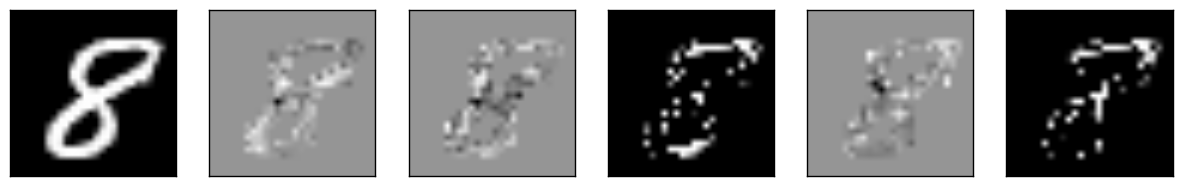

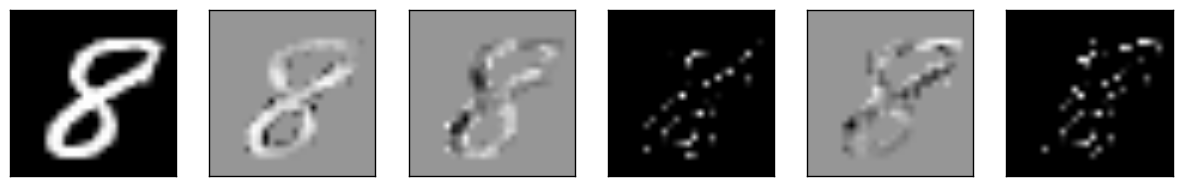

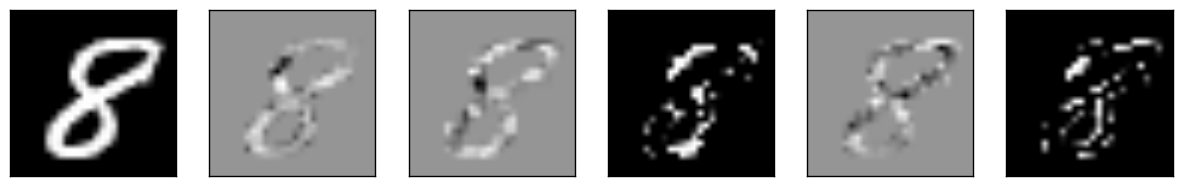

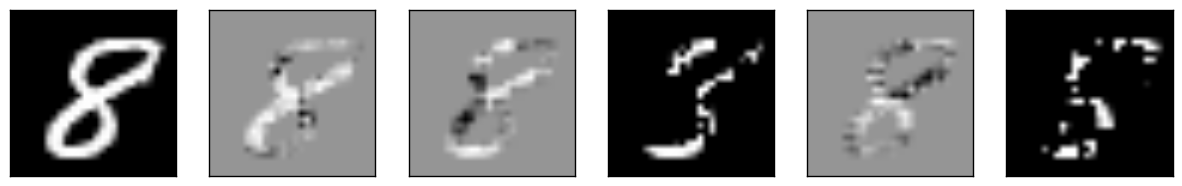

In [16]:
n_to_erase=157
#method_names = [ 'guided_backprop_masked', 'grad_times_inp', 'revealcancel']
method_names = ['simonyan_masked', 'guided_backprop_masked', 'grad_times_inp', 'revealcancel']
#method_names = ['simonyan_masked', 'guided_backprop_masked', 'grad_times_inp', 'integrated_grads_5', 'revealcancel']
plot_two_way_figures(5846,8,3,6,method_names,n_to_erase)

### Plot change in log-odds across all examples in a test set

converting: 8->3
top indices for simonyan_masked: 9516 8440 5846 9450 9917 5803 5744 8223 3892 8437
top indices for guided_backprop_masked: 5846 5650 5797 2774 8157 8437 9516 3807 6654 9609
top indices for guided_backprop_times_inp: 5846 5650 5797 2774 8157 8437 9516 3807 6654 9609
top indices for grad_times_inp: 5846 8157 5797 6654 9917 8015 6435 9516 6212 8440
top indices for integrated_grads_5: 5846 8157 6654 5797 8015 9917 6435 9516 6212 8440
top indices for integrated_grads_10: 5846 8157 6654 5797 8015 9917 6435 6212 8440 8249
top indices for revealcancel: 5846 9917 8157 8547 9574 8437 5797 8872 8466 9516


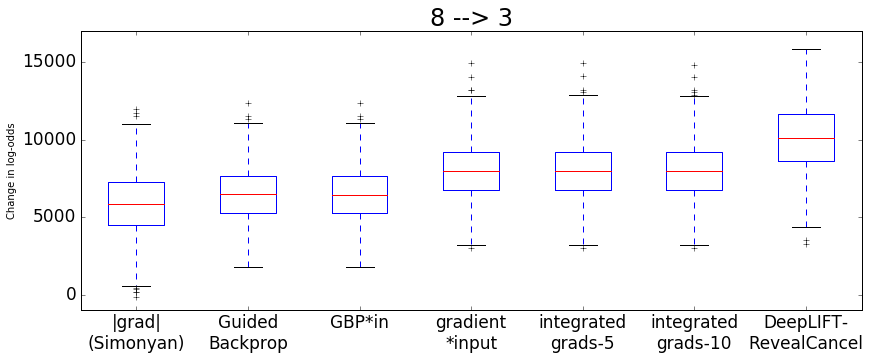

converting: 8->6
top indices for simonyan_masked: 9516 5846 8985 9609 8965 8223 260 3892 486 2774
top indices for guided_backprop_masked: 2470 5846 9609 4246 9516 1118 1074 8300 8009 8985
top indices for guided_backprop_times_inp: 2470 5846 9609 4246 9516 1118 1074 8300 8009 8985
top indices for grad_times_inp: 5857 5846 2470 9516 1118 9609 4246 2451 8985 8965
top indices for integrated_grads_5: 5857 5846 2470 1118 9516 9609 4246 2451 8985 5864
top indices for integrated_grads_10: 5857 5846 9516 2470 1118 9609 4246 2451 8985 5864
top indices for revealcancel: 2470 5857 2213 1118 2451 4246 5864 5846 9516 3829


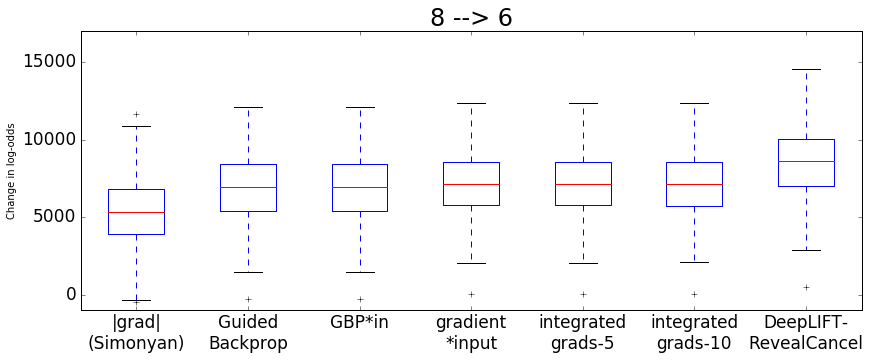

converting: 9->1
top indices for simonyan_masked: 2263 5587 5523 481 4835 2257 8457 2892 5377 6230
top indices for guided_backprop_masked: 5289 5587 2263 3008 6302 8457 2892 6230 5523 5333
top indices for guided_backprop_times_inp: 5289 5587 2263 3008 6302 8457 2892 6230 5523 5333
top indices for grad_times_inp: 3287 2341 99 3008 6302 5523 5587 7347 2263 1793
top indices for integrated_grads_5: 3287 2341 99 3008 6302 5523 5587 7347 2263 1793
top indices for integrated_grads_10: 3287 2341 99 3008 6302 5523 5587 7347 2263 1793
top indices for revealcancel: 2263 6302 3885 5377 1793 8457 5587 9079 4835 8782


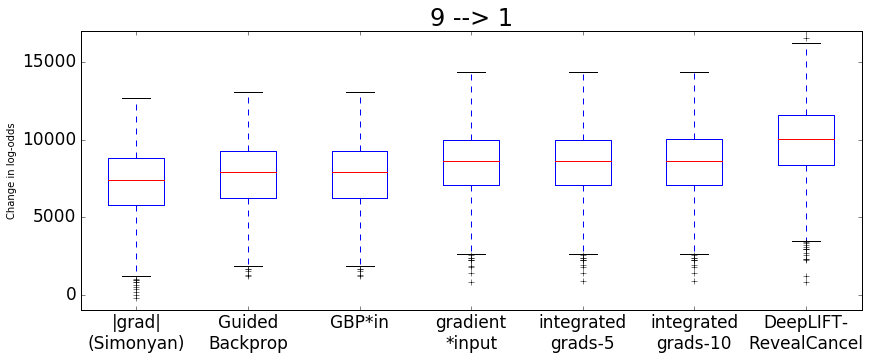

converting: 4->1
top indices for simonyan_masked: 3397 8925 3357 2889 5816 6861 9866 1529 2256 6822
top indices for guided_backprop_masked: 2889 3752 3397 2256 9861 3819 9866 3357 1529 7621
top indices for guided_backprop_times_inp: 2889 3752 3397 2256 9861 3819 9866 3357 1529 7621
top indices for grad_times_inp: 3752 2256 3357 3397 9873 5191 7629 9861 3819 3500
top indices for integrated_grads_5: 3752 3357 2256 3397 9873 3819 7629 8886 9861 2889
top indices for integrated_grads_10: 3752 3357 2256 3397 9873 3819 7629 8886 9861 2889
top indices for revealcancel: 2256 762 9873 1529 2145 2889 5294 3752 3357 3500


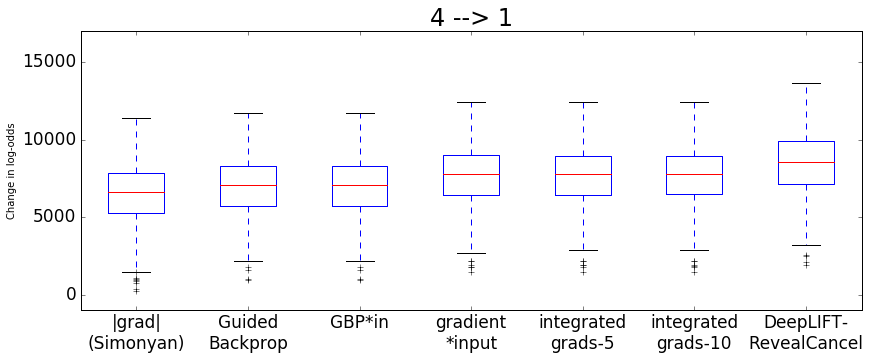

In [15]:
method_names_and_short_names = [
    ('simonyan_masked', '|grad|\n(Simonyan)'),
    ('guided_backprop_masked', 'Guided\nBackprop'),
    ('guided_backprop_times_inp', 'GBP*in'),
    ('grad_times_inp', 'gradient\n*input'),
    ('integrated_grads_5', 'integrated\ngrads-5'),
    ('integrated_grads_10', 'integrated\ngrads-10'),
    ('revealcancel', 'DeepLIFT-\nRevealCancel'),
]

barplot_scores(8,3,method_names_and_short_names, n_to_erase)
barplot_scores(8,6,method_names_and_short_names, n_to_erase)
barplot_scores(9,1,method_names_and_short_names, n_to_erase)
barplot_scores(4,1,method_names_and_short_names, n_to_erase)